In [48]:
!pip install micrograd graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 266.8 kB/s eta 0:00:00a 0:00:01


In [2]:
from micrograd.engine import Value

a = Value(-4.0)
b = Value(2.0)
c = a + b
d = a * b + b**3
c += c + 1
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()
d += 3 * d + (b - a).relu()
e = c - d
f = e**2
g = f / 2.0
g += 10.0 / f
print(f'{g.data:.4f}') # prints 24.7041, the outcome of this forward pass
g.backward()
print(f'{a.grad:.4f}') # prints 138.8338, i.e. the numerical value of dg/da
print(f'{b.grad:.4f}') # prints 645.5773, i.e. the numerical value of dg/db

24.7041
138.8338
645.5773


In [4]:
import math
import numpy as np 
import matplotlib.pyplot as plt

In [5]:
def f(x):
    return 3*x**2-4*x+5

In [7]:
f(3)

20

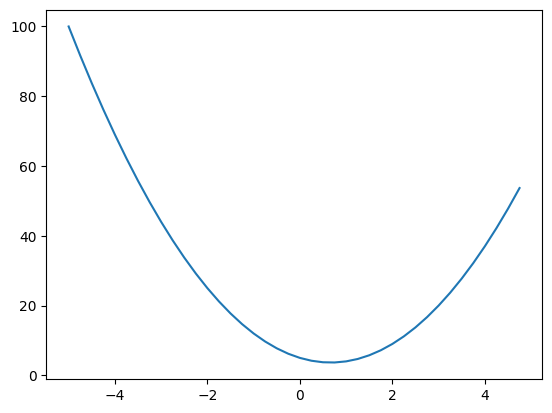

In [8]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [15]:
h = 0.000001
x = 2/3
(f(x+h)-f(x))/h

2.999378523327323e-06

In [19]:
a=2.0
b=-3.0
c=10.
d=a*b+c
d

4.0

In [23]:
h = 0.00001

d1 = a*b+c
a+=h
d2 = a*b+c
print(f"d1:{d1} d2:{d2} slope:{(d2-d1)/h}")

d1:4.0000100002 d2:3.9999800004 slope:-2.9999799999735894


In [22]:
h = 0.00001

d1 = a*b+c
b+=h
d2 = a*b+c
print(f"d1:{d1} d2:{d2} slope:{(d2-d1)/h}")

d1:3.9999900000999995 d2:4.0000100002 slope:2.00001000001393


In [28]:
h = 0.01

d1 = a*b+c
c+=h
d2 = a*b+c
print(f"d1:{d1} d2:{d2} slope:{(d2-d1)/h}")

d1:5.0209900003999985 d2:5.030990000399998 slope:0.9999999999999787


In [295]:
class Value:
    def __init__(self, data, _chidren=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_chidren)
        self._backward = lambda: None
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value=(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data+other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):  # other + self
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data*other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):  # other * self
        return self * other

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):  # self**other
        assert isinstance(other, (float, int)), "only support int/float powers for now"
        out = Value(self.data**(other),(self,),f'**{other}')
        def _backward():
            self.grad+=other*(self.data**(other-1))*out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):  # self/other
        return self*other**-1
    def __neg__(self):
        return self*-1
    def __sub__(self,other):
        return self+(-other)
    def __radd__(self, other): # other + self
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), _op='tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        t = math.exp(x)
        out = Value(t, (self,), _op='exp')

        def _backward():
            self.grad += t*out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b
e.label = 'e'
d = e+c
d.label = 'd'
f = Value(-2.0, label='f')
L = d*f
L.label = 'L'
L

Value=(data=-8.0)

In [168]:
a = Value(2.0)
2*a
2+a
a.exp()
a.backward()

[Value=(data=2.0)]


In [169]:
a = Value(2.0)
b = Value(4.0)
a/b

Value=(data=0.5)

In [65]:
d._prev

{Value=(data=-6.0), Value=(data=10.0)}

In [60]:
d._op

'+'

In [201]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [94]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = -2.
e.grad = -2.
a.grad = -2.*-3.
b.grad = -2.*2.

In [96]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e+c
L = d*f

print(L.data)

-7.286496


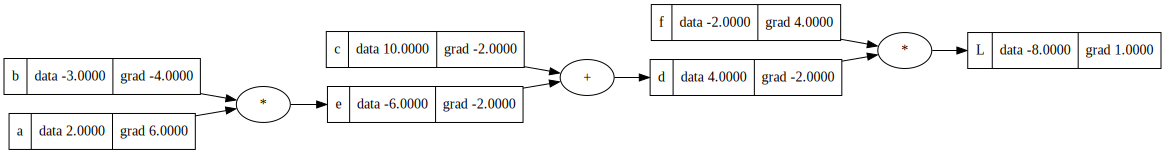

In [95]:
draw_dot(L)

In [82]:
dd/dc = 1
dL/dd =-2.
dL / dc

In [91]:
def lol():
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0,label='f')
    L = d*f;L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    # c.data+=h
    e = a*b; e.label='e'
    e.data+=h
    d = e+c; d.label='d'
    f = Value(-2.0,label='f')
    L = d*f;L.label='L'
    L2 = L.data

    print(L2,L1,h,(L2-L1)/h)

lol()

-8.002 -8.0 0.001 -2.000000000000668


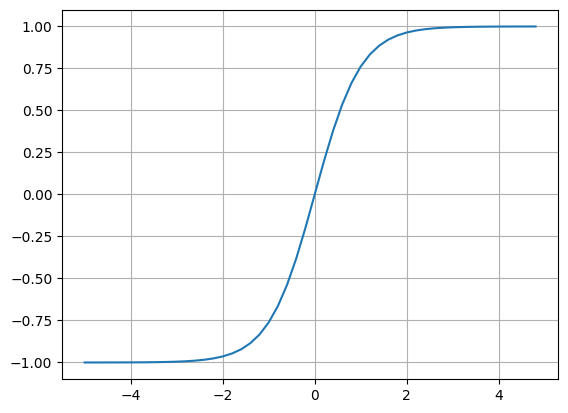

In [99]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

In [131]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b
n.label = 'n'
o = n.tanh()
o.label = 'o'

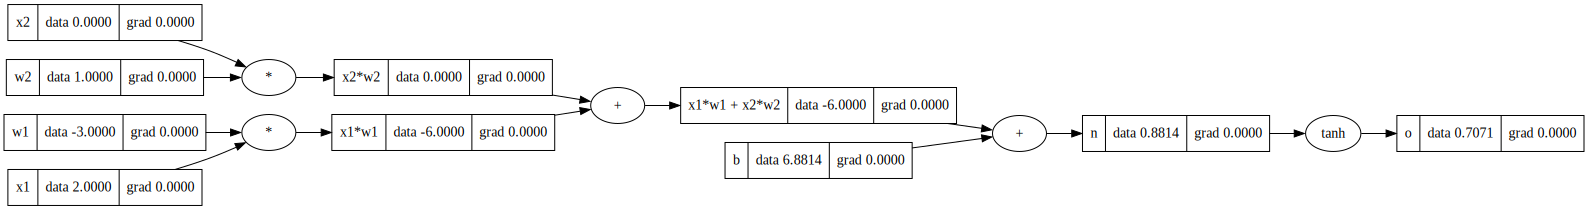

In [124]:
draw_dot(o)

In [125]:
o.backward()

[Value=(data=-3.0), Value=(data=2.0), Value=(data=-6.0), Value=(data=0.0), Value=(data=1.0), Value=(data=0.0), Value=(data=-6.0), Value=(data=6.881373587019543), Value=(data=0.8813735870195432), Value=(data=0.7071067811865476)]


In [135]:
o.grad = 1.0
o._backward()

In [137]:
n._backward()

In [139]:
x1w1x2w2._backward()

In [143]:
x1w1._backward()
x2w2._backward()

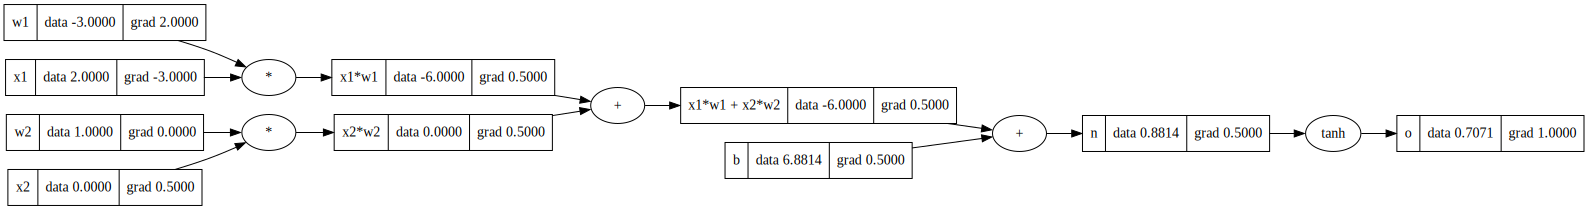

In [144]:
draw_dot(o)

[Value=(data=3.0), Value=(data=6.0)]


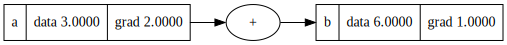

In [146]:
a = Value(3.0,label='a')
b = a+a
b.label='b'
b.backward()
draw_dot(b)

[Value=(data=-2.0), Value=(data=3.0), Value=(data=1.0), Value=(data=-6.0), Value=(data=-6.0)]


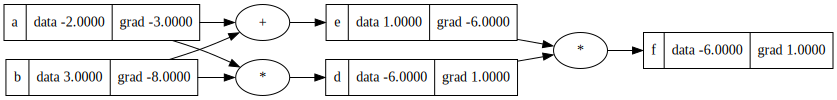

In [147]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

[Value=(data=1.0), Value=(data=0.0), Value=(data=0.0), Value=(data=2.0), Value=(data=-3.0), Value=(data=-6.0), Value=(data=-6.0), Value=(data=6.881373587019543), Value=(data=0.8813735870195432), Value=(data=0.7071067811865476)]


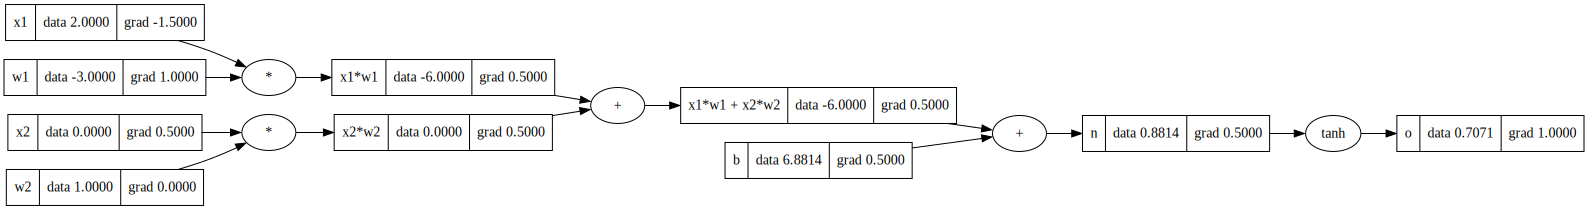

In [174]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b
n.label = 'n'
o1 = n.tanh()
o1.label = 'o'
o1.backward()
draw_dot(o1)

In [170]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b
n.label = 'n'
# o = n.tanh()
# e^2x-1/e^2x+1
e = (2*n).exp()
o = (e-1)/(e+1)
o.label = 'o'

[Value=(data=2), Value=(data=2.0), Value=(data=-3.0), Value=(data=-6.0), Value=(data=0.0), Value=(data=1.0), Value=(data=0.0), Value=(data=-6.0), Value=(data=6.881373587019543), Value=(data=0.8813735870195432), Value=(data=1.7627471740390863), Value=(data=5.828427124746192), Value=(data=-1), Value=(data=4.828427124746192), Value=(data=1), Value=(data=6.828427124746192), Value=(data=0.1464466094067262), Value=(data=0.7071067811865477)]


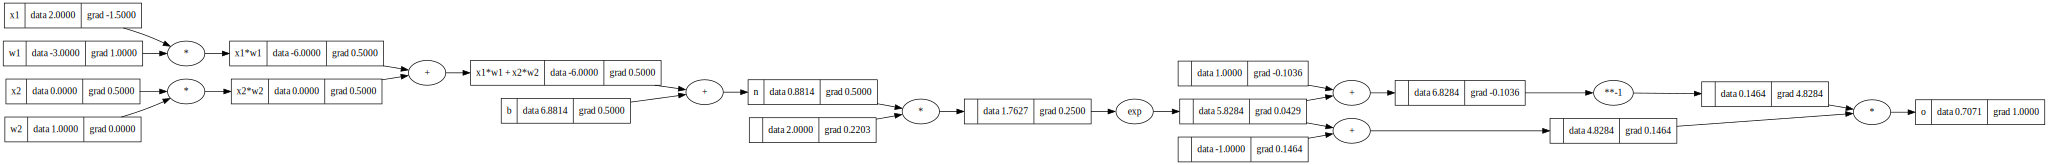

In [172]:
o.backward()
draw_dot(o)

In [175]:
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [177]:
o.item()

0.7071066904050358

In [234]:
import random


class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, -1))

    def __call__(self, x):
        # wx+b
        out = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        return out.tanh()
    def parameters(self):
        return self.w+[self.b]


x = [2.0, 3.0]
n = Neuron(2)
n(x)
n.parameters()

[Value=(data=-0.4776790319025941),
 Value=(data=0.034086379545260614),
 Value=(data=-1.0)]

In [235]:
class Layer:
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

class MLP:
    def __init__(self,nin,nouts):
        sz = [nin]+nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
    def __call__(self,x):
        for l in self.layers:
            x = l(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [236]:
x = [2.,3.]
l = Layer(2,3)
l(x)
l.parameters()

[Value=(data=-0.05038856080636389),
 Value=(data=0.773244622138795),
 Value=(data=-1.0),
 Value=(data=0.8819777682259355),
 Value=(data=-0.10313287474206967),
 Value=(data=-1.0),
 Value=(data=-0.7042329724650163),
 Value=(data=-0.5290040442119159),
 Value=(data=-1.0)]

In [297]:
x = [2., 3.,-1.]
n = MLP(3, [4, 4, 1])
n(x)

Value=(data=-0.9864759794931404)

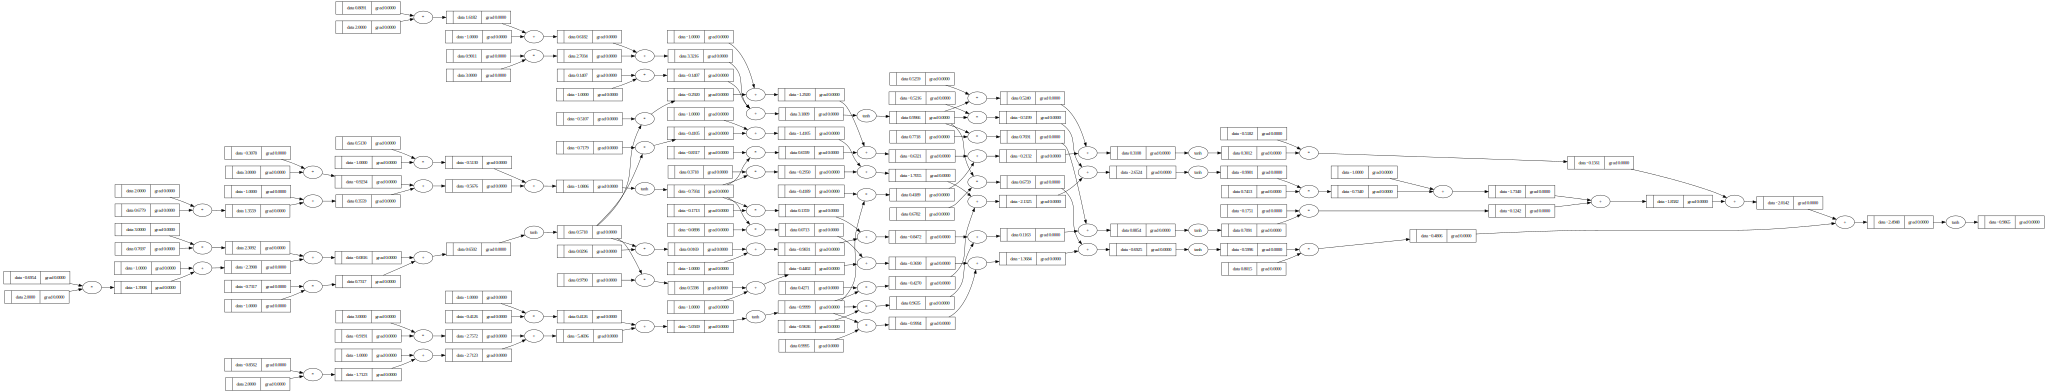

In [298]:
draw_dot(n(x))

In [299]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred

[Value=(data=-0.9864759794931404),
 Value=(data=-0.9628340844635916),
 Value=(data=-0.9904695729154174),
 Value=(data=-0.9920221489363352)]

In [300]:
loss = sum((yout-ygt)**2 for ygt,yout in zip(ys,ypred))
loss

Value=(data=7.915711193274241)

In [301]:
loss.backward()

In [302]:
n.layers[0].neurons[0].w[0].grad

-0.12027509186926426

In [303]:
n.layers[0].neurons[0].w[1].data

0.7697330199307295

In [304]:
for p in n.parameters():
    p.data+=-0.01*p.grad

In [305]:
n.layers[0].neurons[0].w[1].data

0.771460263509587

In [308]:
ypred = [n(x) for x in xs]
loss = sum((yout-ygt)**2 for ygt,yout in zip(ys,ypred))
loss

Value=(data=7.910226702976102)

In [307]:
loss.backward()
for p in n.parameters():
    p.data+=-0.01*p.grad

In [320]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred

n = MLP(3,[4,4,1])


for k in range(50):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)
  

0 7.578814066358703
1 7.22526095544684
2 6.082975463008809
3 4.088841722234003
4 3.9070145564929217
5 4.172679439244842
6 4.7373103394611125
7 3.53192519960259
8 2.930425264302973
9 2.6328408100964964
10 1.835335199184112
11 1.4394195162173715
12 1.0853672611003433
13 1.0281231024992097
14 0.5513714456644249
15 0.29605961395662983
16 0.15215698012674483
17 0.12835269845703542
18 0.1115997112700923
19 0.09853425090230032
20 0.08803047519395389
21 0.07941389564021467
22 0.07222920052774941
23 0.06615545299921875
24 0.060959868000436714
25 0.05646964373973687
26 0.05255394092977573
27 0.04911196816570795
28 0.046064890841211965
29 0.04335020835773183
30 0.04091776635896201
31 0.03872687680287196
32 0.03674420395388982
33 0.03494218959293807
34 0.033297864122926915
35 0.03179193799516839
36 0.030408099560811502
37 0.02913246684431494
38 0.027953155419086762
39 0.026859934794667514
40 0.02584395294999395
41 0.024897513816021004
42 0.024013896252613905
43 0.023187205803164
44 0.0224122525354

In [319]:
ypred

[Value=(data=0.9714008584397545),
 Value=(data=-0.9579379979995125),
 Value=(data=-0.9936784593864736),
 Value=(data=0.9694990044554379)]